# Light 1 Numerical and Data Analysis Answers

In [1]:
%matplotlib inline
import os
import fitsio
import re
import matplotlib
import matplotlib.ticker
import matplotlib.pyplot as plt
import numpy as np
import astropy.coordinates
import astropy.units
from astropy.table import Table
from astropy.io import fits
import requests
import subprocess
from scipy.integrate import simps

## 1. Find and plot optical spectra from SDSS of quasars, galaxies, and stars

There are a number of ways to gather spectra from SDSS. Here, we will first query CasJobs to find good spectra classified in each category. Then we will download their spectra using the SDSS SAS API.

In [2]:
from SciServer import CasJobs
from SciServer import Authentication
from io import StringIO

We will define a convenience function to find different types of objects.

In [3]:
def retrieve_objects(sclass='GALAXY'):
    # We define the columns we want and their 
    columns = ('ra', 'dec', 'z', 'class', 'plate', 'fiberid', 'mjd', 'run2d', 'run1d')
    dtypes= ('f8', 'f8', 'f4', 'S', 'i4', 'i4', 'i4', 'S', 'S')

    # Now define the query
    query = """
SELECT TOP 10 {columns}
FROM specObj 
WHERE class = '{sclass}' and zwarning = 0 and snmedian_r > 8
"""
    query = query.format(columns=', '.join(list(columns)), sclass=sclass)

    # Execute the query (requires internet access)
    responseStream = CasJobs.executeQuery(query, "DR12", format="dict")

    # convert result into astropy table
    result = responseStream['Result'][0]
    data = list(map(list, zip(*result['Data'])))
    objects = Table(data, names=columns, dtype=dtypes)
    return(objects)

Let's find some galaxies and show the information.

In [4]:
galaxies = retrieve_objects(sclass='GALAXY')
galaxies.show_in_notebook()

/home/blanton/anaconda3/lib/python3.11/site-packages/SciServer-2.2.0-py3.11.egg/SciServer/CasJobs.py:143: Warning: In Authentication.getToken: Authentication token is not defined: the user did not log in with the Authentication.login function, or the token has not been stored in the command line argument --ident.


idx,ra,dec,z,class,plate,fiberid,mjd,run2d,run1d
0,215.04742,25.345426,0.0788727,GALAXY,2128,575,53800,26,
1,214.60311,25.114103,0.01650546,GALAXY,2128,577,53800,26,
2,214.79685,25.173384,0.07925931,GALAXY,2128,578,53800,26,
3,215.07301,25.025921,0.06886992,GALAXY,2128,579,53800,26,
4,214.87019,24.678506,0.05472199,GALAXY,2128,581,53800,26,
5,214.78653,24.852944,0.1652594,GALAXY,2128,582,53800,26,
6,214.72779,24.974805,0.1762732,GALAXY,2128,584,53800,26,
7,214.69502,24.937002,0.01809064,GALAXY,2128,585,53800,26,
8,214.89442,24.812244,0.3367326,GALAXY,2128,586,53800,26,
9,214.75578,24.943717,0.01787376,GALAXY,2128,587,53800,26,


Now we will download and plot the spectrum of one of the galaxies. This cell will write a file into your local directory called galaxy.fits.

In [5]:
request_template = 'https://dr15.sdss.org/sas/dr15/sdss/spectro/redux/26/spectra/lite/{plate}/spec-{plate}-{mjd}-{fiberid:04d}.fits'
igalaxy = 5
request = request_template.format(plate=galaxies['plate'][igalaxy], fiberid=galaxies['fiberid'][igalaxy], mjd=galaxies['mjd'][igalaxy])
print(request)
r = requests.get(request)
fp = open('galaxy.fits', 'wb')
fp.write(r.content)
fp.close()

https://dr15.sdss.org/sas/dr15/sdss/spectro/redux/26/spectra/lite/2128/spec-2128-53800-0582.fits


Now we plot it. Note that "loglam" is the base-10 logarithm of the wavelength in Angstroms, and flux is in $10^{-17}$ erg/cm$^2$/s/A, for this particular spectrum. The broad underlying continuum light is due to stars. The sharp spikes upward are called emission lines and are emitted by ionized gas in between the stars. This particular spectrum has a fair amount of noise.

[( 4.064255 , 3.5821, 0.13088146,     0,     0, 1.0918819 , 8.589233 , 5.9752674)
 ( 3.2868426, 3.5822, 0.13934234,     0,     0, 1.0920669 , 8.276097 , 6.009358 )
 ( 7.781187 , 3.5823, 0.13145801,     0,     0, 1.0927049 , 7.836267 , 5.973257 )
 ...
 (10.16117  , 3.9643, 0.52255166, 65552, 65552, 0.73764545, 3.3367045, 9.359417 )
 (10.519975 , 3.9644, 0.4954921 , 65552, 65552, 0.7380102 , 4.067776 , 9.3943   )
 ( 8.652355 , 3.9645, 0.47800976, 65552, 65552, 0.7384527 , 4.9182296, 9.311193 )]


Text(0, 0.5, '$f_\\lambda$ ($10^{-17}$ erg/cm$^2$/s/Angstrom)')

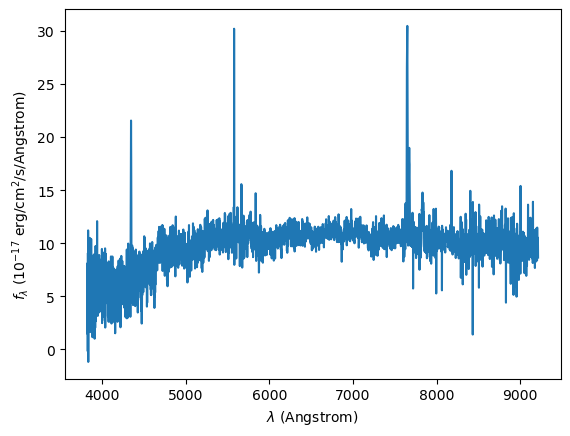

In [6]:
data = fitsio.read('galaxy.fits')
print(data)
plt.plot(10.**data['loglam'], data['flux'])
plt.xlabel('$\lambda$ (Angstrom)')
plt.ylabel('$f_\lambda$ ($10^{-17}$ erg/cm$^2$/s/Angstrom)')

We can smooth this spectrum. Here we choose to smooth the spectrum with a Gaussian with $R\sim 1000$ in terms of full-width half maximum. In $\log_{10}\lambda$ coordinates (i.e. what loglam is in) the FWHM is $(1/R/\ln 10)$. Therefore we should convolve with the Gaussian:

$$\frac{1}{\sqrt{2\pi} \sigma} \exp\left[\frac{1}{2} \frac{\Delta{\rm loglam}^2}{\sigma^2}\right]$$

where:

$$\sigma = \frac{1}{2\sqrt{2\ln 2}} \frac{1}{R\ln 10}$$

The code below creates a kernel with the same log wavelength scale as the data, corresponding to $R=1000$.

In [7]:
R = 1000
sigma = (1. / (2. * np.sqrt(2. * np.log(2)))) * (1./(R * np.log(10)))
dpix = data['loglam'][1] - data['loglam'][0]
kernel_npix = (np.int32(np.floor(10. * sigma / dpix)) // 2) * 2 + 1
kernel_xcen = np.float32(kernel_npix // 2)
kernel_x = (np.arange(kernel_npix) - kernel_xcen) * dpix
kernel = np.exp(- 0.5 * (kernel_x / sigma)**2) / (np.sqrt(2 * np.pi) * sigma)

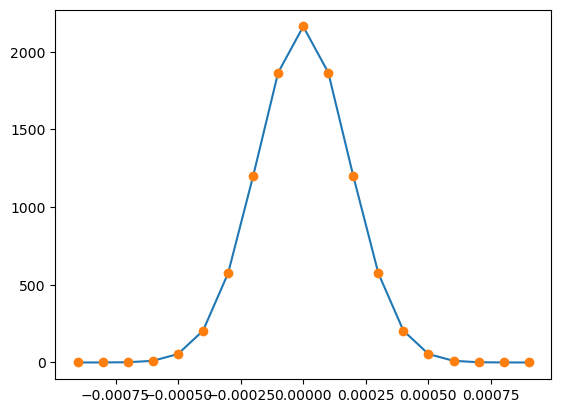

In [8]:
plt.plot(kernel_x, kernel)
plt.plot(kernel_x, kernel, 'o')

We can then convolve the flux with this kernel. We end up seeing the features of the galaxy spectrum at higher signal-to-noise, though also at lower resolution. (Note that in a statistical sense the pixels of the smoother spectrum now have strong off-diagonal covariances).

Text(0, 0.5, '$f_\\lambda$ ($10^{-17}$ erg/cm$^2$/s/Angstrom)')

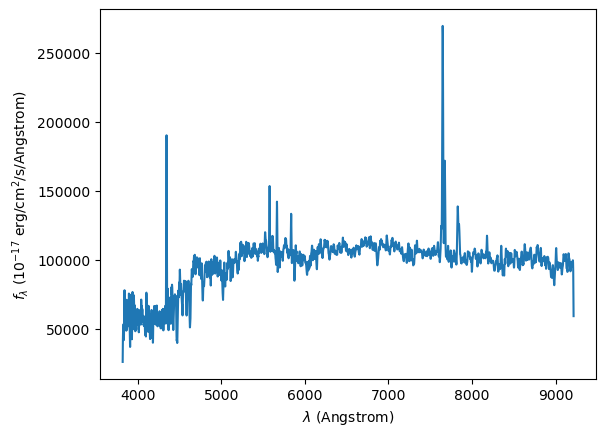

In [9]:
sflux = np.convolve(data['flux'], kernel, mode='same')
plt.plot(10.**data['loglam'], sflux)
plt.xlabel('$\lambda$ (Angstrom)')
plt.ylabel('$f_\lambda$ ($10^{-17}$ erg/cm$^2$/s/Angstrom)')

Now a quasar. In this case the very blue continuum is due to emission from the accretion disk surrounding the massive black hole. There are emission lines in this quasar but they are broad, because of the high random velocities of the emitting gas, which is within a few parsecs of the black hole.

/home/blanton/anaconda3/lib/python3.11/site-packages/SciServer-2.2.0-py3.11.egg/SciServer/CasJobs.py:143: Warning: In Authentication.getToken: Authentication token is not defined: the user did not log in with the Authentication.login function, or the token has not been stored in the command line argument --ident.


Text(0, 0.5, '$f_\\lambda$ ($10^{-17}$ erg/cm$^2$/s/Angstrom)')

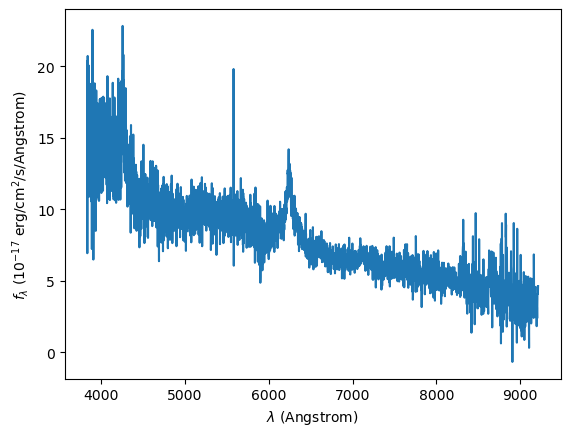

In [10]:
qsos = retrieve_objects(sclass='QSO')
iqso = 5
request = request_template.format(plate=qsos['plate'][iqso], fiberid=qsos['fiberid'][iqso], mjd=qsos['mjd'][iqso])
r = requests.get(request)
fp = open('qso.fits', 'wb')
fp.write(r.content)
fp.close()
data = fitsio.read('qso.fits')
plt.plot(10.**data['loglam'], data['flux'])
plt.xlabel('$\lambda$ (Angstrom)')
plt.ylabel('$f_\lambda$ ($10^{-17}$ erg/cm$^2$/s/Angstrom)')

Finally a star. This star is an A star. The Balmer line absorption sequence can clearly be seen.

In [11]:
stars = retrieve_objects(sclass='STAR')
istar = 1
stars.show_in_notebook()

/home/blanton/anaconda3/lib/python3.11/site-packages/SciServer-2.2.0-py3.11.egg/SciServer/CasJobs.py:143: Warning: In Authentication.getToken: Authentication token is not defined: the user did not log in with the Authentication.login function, or the token has not been stored in the command line argument --ident.


idx,ra,dec,z,class,plate,fiberid,mjd,run2d,run1d
0,215.54565,24.502275,0.0003754675,STAR,2128,634,53800,26,
1,215.40459,24.616114,-9.781437e-05,STAR,2128,636,53800,26,
2,160.94689,17.745501,5.038096e-05,STAR,5886,266,56034,v5_7_0,v5_7_0
3,160.89154,17.987414,9.161198e-05,STAR,5886,267,56034,v5_7_0,v5_7_0
4,160.80008,18.010767,-0.0002844355,STAR,5886,306,56034,v5_7_0,v5_7_0
5,188.95863,44.607485,-0.000657774,STAR,6636,110,56367,v5_7_0,v5_7_0
6,188.44258,43.698882,-9.122994e-05,STAR,6636,122,56367,v5_7_0,v5_7_0
7,188.5286,44.520898,0.0002768423,STAR,6636,154,56367,v5_7_0,v5_7_0
8,188.68306,44.490236,-0.0001572999,STAR,6636,160,56367,v5_7_0,v5_7_0
9,124.65631,25.612326,9.79433e-06,STAR,4461,438,55888,v5_7_0,v5_7_0


https://dr15.sdss.org/sas/dr15/sdss/spectro/redux/26/spectra/lite/2128/spec-2128-53800-0636.fits


Text(0, 0.5, '$f_\\lambda$ ($10^{-17}$ erg/cm$^2$/s/Angstrom)')

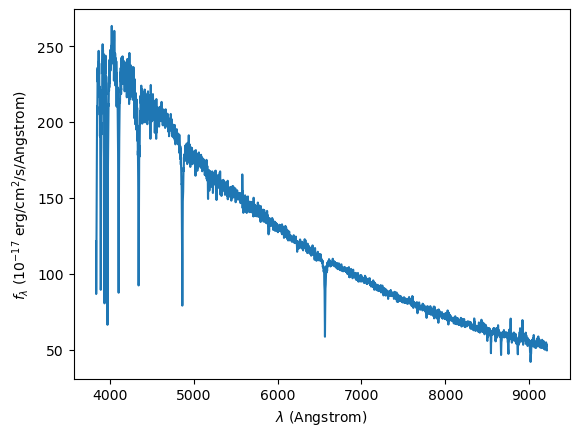

In [12]:
request = request_template.format(plate=stars['plate'][istar], fiberid=stars['fiberid'][istar], mjd=stars['mjd'][istar])
print(request)
r = requests.get(request)
fp = open('star.fits', 'wb')
fp.write(r.content)
fp.close()
data = fitsio.read('star.fits')
plt.plot(10.**data['loglam'], data['flux'])
plt.xlabel('$\lambda$ (Angstrom)')
plt.ylabel('$f_\lambda$ ($10^{-17}$ erg/cm$^2$/s/Angstrom)')

Now convert to $f_\nu$.

Text(0, 0.5, '$f_\\nu$ (mJy)')

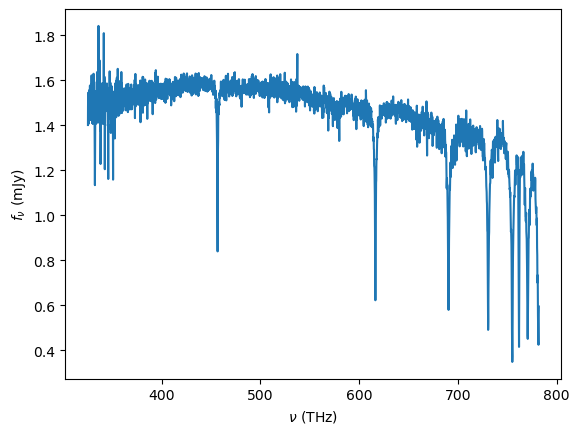

In [13]:
cspeed = 2.99792e+18 # Angstrom / s
nu = cspeed / 10.**data['loglam'] / 1.e+12 # into terahertz
fnu = data['flux'] * 10.**(2.*data['loglam']) / cspeed * (1.e-17 / 1.e-23 * 1.e+3) # into mJy
plt.plot(nu, fnu)
plt.xlabel(r'$\nu$ (THz)')
plt.ylabel(r'$f_\nu$ (mJy)')

## 3. K-corrections

*Author: Nanoom Lee*

Download the filter curve for the SDSS $g$ and $r$
bands. Calculate the observed $g$ and $r$ band magnitudes
corresponding to a galaxy spectrum (say for some galaxy with
$z\sim0.15$ or greater). Note that this won't necessarily be the same as the
magnitudes measured from the images, since the spectra are taken
through 2- or 3-arcsec diameter fibers. Calculate the rest-frame
$g-r$ color, and also what the $K$-correction would be for galaxies
with this SED in the $r$-band between about $z\sim 0$ and $z\sim
0.25$. Download the photometric data for a sample of galaxies between 
about $z\sim 0$ and
$0.25$. Plot their $g-r$ colors versus redshift, together with the
predicted colors of the galaxy you have a spectrum of.


In [14]:
filter_curve_file = 'https://www.sdss4.org/wp-content/uploads/2017/04/filter_curves.fits'
r = requests.get(filter_curve_file)
fp = open('filter_curves.fits', 'wb')
fp.write(r.content)
fp.close()

In [15]:
# This code assumes there is a list of URLs with a form similar to that above for spectra in the download_url.txt file.
c = 299792458.    # speed of light in m/s
subprocess.call('wget -i download_url.txt', shell = True)

--2024-09-22 20:11:05--  https://data.sdss.org/sas/dr16/sdss/spectro/redux/26/spectra/lite/0274/spec-0274-51913-0001.fits
Resolving data.sdss.org (data.sdss.org)... 155.101.19.133
Connecting to data.sdss.org (data.sdss.org)|155.101.19.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0001.fits.3’

     0K .......... .......... .......... .......... .......... 29%  542K 0s
    50K .......... .......... .......... .......... .......... 58%  899K 0s
   100K .......... .......... .......... .......... .......... 87% 6.08M 0s
   150K .......... .......... .                               100% 19.4M=0.2s

2024-09-22 20:11:05 (1.07 MB/s) - ‘spec-0274-51913-0001.fits.3’ saved [175680/175680]

--2024-09-22 20:11:05--  https://data.sdss.org/sas/dr16/sdss/spectro/redux/26/spectra/lite/0274/spec-0274-51913-0002.fits
Reusing existing connection to data.sdss.org:443.
HTTP request sent, awaiting response..

HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0014.fits.3’

     0K .......... .......... .......... .......... .......... 29% 6.80M 0s
    50K .......... .......... .......... .......... .......... 58% 5.89M 0s
   100K .......... .......... .......... .......... .......... 87% 19.4M 0s
   150K .......... .......... .                               100% 16.4M=0.02s

2024-09-22 20:11:06 (8.69 MB/s) - ‘spec-0274-51913-0014.fits.3’ saved [175680/175680]

--2024-09-22 20:11:06--  https://data.sdss.org/sas/dr16/sdss/spectro/redux/26/spectra/lite/0274/spec-0274-51913-0015.fits
Reusing existing connection to data.sdss.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0015.fits.3’

     0K .......... .......... .......... .......... .......... 29% 5.71M 0s
    50K .......... .......... .......... .......... .......... 58% 21.1M 0s
   10

HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0027.fits.3’

     0K .......... .......... .......... .......... .......... 29% 7.66M 0s
    50K .......... .......... .......... .......... .......... 58% 18.5M 0s
   100K .......... .......... .......... .......... .......... 87% 7.56M 0s
   150K .......... .......... .                               100%  224M=0.02s

2024-09-22 20:11:07 (10.8 MB/s) - ‘spec-0274-51913-0027.fits.3’ saved [175680/175680]

--2024-09-22 20:11:07--  https://data.sdss.org/sas/dr16/sdss/spectro/redux/26/spectra/lite/0274/spec-0274-51913-0028.fits
Reusing existing connection to data.sdss.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0028.fits.3’

     0K .......... .......... .......... .......... .......... 29% 13.9M 0s
    50K .......... .......... .......... .......... .......... 58% 9.85M 0s
   10

HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0039.fits.3’

     0K .......... .......... .......... .......... .......... 29% 10.9M 0s
    50K .......... .......... .......... .......... .......... 58% 19.2M 0s
   100K .......... .......... .......... .......... .......... 87% 8.27M 0s
   150K .......... .......... .                               100%  207M=0.01s

2024-09-22 20:11:08 (12.8 MB/s) - ‘spec-0274-51913-0039.fits.3’ saved [175680/175680]

--2024-09-22 20:11:08--  https://data.sdss.org/sas/dr16/sdss/spectro/redux/26/spectra/lite/0274/spec-0274-51913-0040.fits
Reusing existing connection to data.sdss.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0040.fits.3’

     0K .......... .......... .......... .......... .......... 29% 13.5M 0s
    50K .......... .......... .......... .......... .......... 58% 7.10M 0s
   10

HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0052.fits.3’

     0K .......... .......... .......... .......... .......... 29% 19.6M 0s
    50K .......... .......... .......... .......... .......... 58% 8.12M 0s
   100K .......... .......... .......... .......... .......... 87% 7.91M 0s
   150K .......... .......... .                               100% 7.46M=0.02s

2024-09-22 20:11:09 (9.57 MB/s) - ‘spec-0274-51913-0052.fits.3’ saved [175680/175680]

--2024-09-22 20:11:09--  https://data.sdss.org/sas/dr16/sdss/spectro/redux/26/spectra/lite/0274/spec-0274-51913-0053.fits
Reusing existing connection to data.sdss.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0053.fits.3’

     0K .......... .......... .......... .......... .......... 29% 8.51M 0s
    50K .......... .......... .......... .......... .......... 58% 14.7M 0s
   10

HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0065.fits.3’

     0K .......... .......... .......... .......... .......... 29% 16.5M 0s
    50K .......... .......... .......... .......... .......... 58% 7.10M 0s
   100K .......... .......... .......... .......... .......... 87% 9.29M 0s
   150K .......... .......... .                               100% 39.5M=0.02s

2024-09-22 20:11:10 (10.7 MB/s) - ‘spec-0274-51913-0065.fits.3’ saved [175680/175680]

--2024-09-22 20:11:10--  https://data.sdss.org/sas/dr16/sdss/spectro/redux/26/spectra/lite/0274/spec-0274-51913-0066.fits
Reusing existing connection to data.sdss.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0066.fits.3’

     0K .......... .......... .......... .......... .......... 29% 10.2M 0s
    50K .......... .......... .......... .......... .......... 58% 10.6M 0s
   10

HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0080.fits.3’

     0K .......... .......... .......... .......... .......... 29% 3.64M 0s
    50K .......... .......... .......... .......... .......... 58% 21.6M 0s
   100K .......... .......... .......... .......... .......... 87% 6.57M 0s
   150K .......... .......... .                               100% 11.7M=0.02s

2024-09-22 20:11:11 (6.72 MB/s) - ‘spec-0274-51913-0080.fits.3’ saved [175680/175680]

--2024-09-22 20:11:11--  https://data.sdss.org/sas/dr16/sdss/spectro/redux/26/spectra/lite/0274/spec-0274-51913-0081.fits
Reusing existing connection to data.sdss.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0081.fits.3’

     0K .......... .......... .......... .......... .......... 29% 7.96M 0s
    50K .......... .......... .......... .......... .......... 58% 9.16M 0s
   10

HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0093.fits.3’

     0K .......... .......... .......... .......... .......... 29% 7.36M 0s
    50K .......... .......... .......... .......... .......... 58% 12.7M 0s
   100K .......... .......... .......... .......... .......... 87% 10.1M 0s
   150K .......... .......... .                               100%  155M=0.02s

2024-09-22 20:11:12 (10.8 MB/s) - ‘spec-0274-51913-0093.fits.3’ saved [175680/175680]

--2024-09-22 20:11:12--  https://data.sdss.org/sas/dr16/sdss/spectro/redux/26/spectra/lite/0274/spec-0274-51913-0094.fits
Reusing existing connection to data.sdss.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0094.fits.3’

     0K .......... .......... .......... .......... .......... 29% 4.68M 0s
    50K .......... .......... .......... .......... .......... 58% 18.2M 0s
   10

HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0105.fits.3’

     0K .......... .......... .......... .......... .......... 29% 6.49M 0s
    50K .......... .......... .......... .......... .......... 58% 17.0M 0s
   100K .......... .......... .......... .......... .......... 87% 11.5M 0s
   150K .......... .......... .                               100% 21.3M=0.02s

2024-09-22 20:11:13 (10.7 MB/s) - ‘spec-0274-51913-0105.fits.3’ saved [175680/175680]

--2024-09-22 20:11:13--  https://data.sdss.org/sas/dr16/sdss/spectro/redux/26/spectra/lite/0274/spec-0274-51913-0106.fits
Reusing existing connection to data.sdss.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0106.fits.3’

     0K .......... .......... .......... .......... .......... 29% 9.85M 0s
    50K .......... .......... .......... .......... .......... 58% 12.7M 0s
   10

HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0119.fits.3’

     0K .......... .......... .......... .......... .......... 29% 9.95M 0s
    50K .......... .......... .......... .......... .......... 58% 13.2M 0s
   100K .......... .......... .......... .......... .......... 87% 7.13M 0s
   150K .......... .......... .                               100%  361M=0.02s

2024-09-22 20:11:14 (10.8 MB/s) - ‘spec-0274-51913-0119.fits.3’ saved [175680/175680]

--2024-09-22 20:11:14--  https://data.sdss.org/sas/dr16/sdss/spectro/redux/26/spectra/lite/0274/spec-0274-51913-0120.fits
Reusing existing connection to data.sdss.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0120.fits.3’

     0K .......... .......... .......... .......... .......... 29% 7.88M 0s
    50K .......... .......... .......... .......... .......... 58% 18.8M 0s
   10

HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0132.fits.3’

     0K .......... .......... .......... .......... .......... 29% 9.25M 0s
    50K .......... .......... .......... .......... .......... 58% 7.66M 0s
   100K .......... .......... .......... .......... .......... 87% 7.87M 0s
   150K .......... .......... .                               100% 21.2M=0.02s

2024-09-22 20:11:14 (8.89 MB/s) - ‘spec-0274-51913-0132.fits.3’ saved [175680/175680]

--2024-09-22 20:11:14--  https://data.sdss.org/sas/dr16/sdss/spectro/redux/26/spectra/lite/0274/spec-0274-51913-0133.fits
Reusing existing connection to data.sdss.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0133.fits.3’

     0K .......... .......... .......... .......... .......... 29%  149M 0s
    50K .......... .......... .......... .......... .......... 58% 7.40M 0s
   10

HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0146.fits.3’

     0K .......... .......... .......... .......... .......... 29% 2.41M 0s
    50K .......... .......... .......... .......... .......... 58%  230M 0s
   100K .......... .......... .......... .......... .......... 87% 7.39M 0s
   150K .......... .......... .                               100%  206M=0.03s

2024-09-22 20:11:16 (6.17 MB/s) - ‘spec-0274-51913-0146.fits.3’ saved [175680/175680]

--2024-09-22 20:11:16--  https://data.sdss.org/sas/dr16/sdss/spectro/redux/26/spectra/lite/0274/spec-0274-51913-0147.fits
Reusing existing connection to data.sdss.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0147.fits.3’

     0K .......... .......... .......... .......... .......... 29% 7.19M 0s
    50K .......... .......... .......... .......... .......... 58% 10.6M 0s
   10

HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0159.fits.3’

     0K .......... .......... .......... .......... .......... 29% 10.2M 0s
    50K .......... .......... .......... .......... .......... 58% 9.78M 0s
   100K .......... .......... .......... .......... .......... 87% 19.6M 0s
   150K .......... .......... .                               100% 22.9M=0.01s

2024-09-22 20:11:16 (12.7 MB/s) - ‘spec-0274-51913-0159.fits.3’ saved [175680/175680]

--2024-09-22 20:11:16--  https://data.sdss.org/sas/dr16/sdss/spectro/redux/26/spectra/lite/0274/spec-0274-51913-0160.fits
Reusing existing connection to data.sdss.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0160.fits.3’

     0K .......... .......... .......... .......... .......... 29% 3.96M 0s
    50K .......... .......... .......... .......... .......... 58% 21.9M 0s
   10

HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0172.fits.3’

     0K .......... .......... .......... .......... .......... 29% 42.2M 0s
    50K .......... .......... .......... .......... .......... 58% 9.18M 0s
   100K .......... .......... .......... .......... .......... 87% 10.5M 0s
   150K .......... .......... .                               100% 54.7M=0.01s

2024-09-22 20:11:17 (14.5 MB/s) - ‘spec-0274-51913-0172.fits.3’ saved [175680/175680]

--2024-09-22 20:11:17--  https://data.sdss.org/sas/dr16/sdss/spectro/redux/26/spectra/lite/0274/spec-0274-51913-0173.fits
Reusing existing connection to data.sdss.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0173.fits.3’

     0K .......... .......... .......... .......... .......... 29% 7.46M 0s
    50K .......... .......... .......... .......... .......... 58% 12.8M 0s
   10

HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0186.fits.3’

     0K .......... .......... .......... .......... .......... 29% 11.0M 0s
    50K .......... .......... .......... .......... .......... 58% 9.09M 0s
   100K .......... .......... .......... .......... .......... 87% 9.48M 0s
   150K .......... .......... .                               100%  172M=0.02s

2024-09-22 20:11:18 (11.1 MB/s) - ‘spec-0274-51913-0186.fits.3’ saved [175680/175680]

--2024-09-22 20:11:18--  https://data.sdss.org/sas/dr16/sdss/spectro/redux/26/spectra/lite/0274/spec-0274-51913-0187.fits
Reusing existing connection to data.sdss.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0187.fits.3’

     0K .......... .......... .......... .......... .......... 29% 10.1M 0s
    50K .......... .......... .......... .......... .......... 58% 9.81M 0s
   10

HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0198.fits.3’

     0K .......... .......... .......... .......... .......... 29% 6.11M 0s
    50K .......... .......... .......... .......... .......... 58% 10.2M 0s
   100K .......... .......... .......... .......... .......... 87% 9.94M 0s
   150K .......... .......... .                               100%  122M=0.02s

2024-09-22 20:11:19 (9.38 MB/s) - ‘spec-0274-51913-0198.fits.3’ saved [175680/175680]

--2024-09-22 20:11:19--  https://data.sdss.org/sas/dr16/sdss/spectro/redux/26/spectra/lite/0274/spec-0274-51913-0199.fits
Reusing existing connection to data.sdss.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0199.fits.3’

     0K .......... .......... .......... .......... .......... 29% 7.98M 0s
    50K .......... .......... .......... .......... .......... 58% 11.5M 0s
   10

HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0212.fits.3’

     0K .......... .......... .......... .......... .......... 29% 9.39M 0s
    50K .......... .......... .......... .......... .......... 58% 21.6M 0s
   100K .......... .......... .......... .......... .......... 87% 10.1M 0s
   150K .......... .......... .                               100%  122M=0.01s

2024-09-22 20:11:20 (13.5 MB/s) - ‘spec-0274-51913-0212.fits.3’ saved [175680/175680]

--2024-09-22 20:11:20--  https://data.sdss.org/sas/dr16/sdss/spectro/redux/26/spectra/lite/0274/spec-0274-51913-0213.fits
Reusing existing connection to data.sdss.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0213.fits.3’

     0K .......... .......... .......... .......... .......... 29% 9.66M 0s
    50K .......... .......... .......... .......... .......... 58% 20.2M 0s
   10

HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0226.fits.3’

     0K .......... .......... .......... .......... .......... 29% 26.9M 0s
    50K .......... .......... .......... .......... .......... 58% 9.58M 0s
   100K .......... .......... .......... .......... .......... 87% 7.73M 0s
   150K .......... .......... .                               100%  154M=0.01s

2024-09-22 20:11:21 (12.5 MB/s) - ‘spec-0274-51913-0226.fits.3’ saved [175680/175680]

--2024-09-22 20:11:21--  https://data.sdss.org/sas/dr16/sdss/spectro/redux/26/spectra/lite/0274/spec-0274-51913-0227.fits
Reusing existing connection to data.sdss.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0227.fits.3’

     0K .......... .......... .......... .......... .......... 29% 11.8M 0s
    50K .......... .......... .......... .......... .......... 58% 9.80M 0s
   10

HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0238.fits.3’

     0K .......... .......... .......... .......... .......... 29% 4.38M 0s
    50K .......... .......... .......... .......... .......... 58% 21.7M 0s
   100K .......... .......... .......... .......... .......... 87% 10.8M 0s
   150K .......... .......... .                               100%  160M=0.02s

2024-09-22 20:11:22 (9.28 MB/s) - ‘spec-0274-51913-0238.fits.3’ saved [175680/175680]

--2024-09-22 20:11:22--  https://data.sdss.org/sas/dr16/sdss/spectro/redux/26/spectra/lite/0274/spec-0274-51913-0239.fits
Reusing existing connection to data.sdss.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0239.fits.3’

     0K .......... .......... .......... .......... .......... 29% 5.90M 0s
    50K .......... .......... .......... .......... .......... 58% 10.9M 0s
   10

    50K .......... .......... .......... .......... .......... 58% 1.39M 0s
   100K .......... .......... .......... .......... .......... 87% 34.1M 0s
   150K .......... .......... .                               100%  186M=0.04s

2024-09-22 20:11:23 (4.06 MB/s) - ‘spec-0274-51913-0253.fits.3’ saved [175680/175680]

--2024-09-22 20:11:23--  https://data.sdss.org/sas/dr16/sdss/spectro/redux/26/spectra/lite/0274/spec-0274-51913-0254.fits
Reusing existing connection to data.sdss.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0254.fits.3’

     0K .......... .......... .......... .......... .......... 29% 9.84M 0s
    50K .......... .......... .......... .......... .......... 58% 7.41M 0s
   100K .......... .......... .......... .......... .......... 87% 12.7M 0s
   150K .......... .......... .                               100%  269M=0.02s

2024-09-22 20:11:23 (10.8 MB/s) - ‘spec-0274-51913-0254.fits.3’

HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0266.fits.3’

     0K .......... .......... .......... .......... .......... 29% 5.40M 0s
    50K .......... .......... .......... .......... .......... 58% 33.2M 0s
   100K .......... .......... .......... .......... .......... 87% 8.89M 0s
   150K .......... .......... .                               100% 5.10M=0.02s

2024-09-22 20:11:24 (8.32 MB/s) - ‘spec-0274-51913-0266.fits.3’ saved [175680/175680]

--2024-09-22 20:11:24--  https://data.sdss.org/sas/dr16/sdss/spectro/redux/26/spectra/lite/0274/spec-0274-51913-0267.fits
Reusing existing connection to data.sdss.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0267.fits.3’

     0K .......... .......... .......... .......... .......... 29% 5.13M 0s
    50K .......... .......... .......... .......... .......... 58% 10.2M 0s
   10

HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0278.fits.3’

     0K .......... .......... .......... .......... .......... 29% 10.1M 0s
    50K .......... .......... .......... .......... .......... 58% 11.0M 0s
   100K .......... .......... .......... .......... .......... 87% 19.7M 0s
   150K .......... .......... .                               100% 7.02M=0.01s

2024-09-22 20:11:25 (11.3 MB/s) - ‘spec-0274-51913-0278.fits.3’ saved [175680/175680]

--2024-09-22 20:11:25--  https://data.sdss.org/sas/dr16/sdss/spectro/redux/26/spectra/lite/0274/spec-0274-51913-0280.fits
Reusing existing connection to data.sdss.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0280.fits.3’

     0K .......... .......... .......... .......... .......... 29%  272M 0s
    50K .......... .......... .......... .......... .......... 58% 9.32M 0s
   10

HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0293.fits.3’

     0K .......... .......... .......... .......... .......... 29% 10.5M 0s
    50K .......... .......... .......... .......... .......... 58% 19.3M 0s
   100K .......... .......... .......... .......... .......... 87% 20.7M 0s
   150K .......... .......... .                               100% 23.4M=0.01s

2024-09-22 20:11:26 (16.0 MB/s) - ‘spec-0274-51913-0293.fits.3’ saved [175680/175680]

--2024-09-22 20:11:26--  https://data.sdss.org/sas/dr16/sdss/spectro/redux/26/spectra/lite/0274/spec-0274-51913-0295.fits
Reusing existing connection to data.sdss.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0295.fits.3’

     0K .......... .......... .......... .......... .......... 29% 6.54M 0s
    50K .......... .......... .......... .......... .......... 58% 22.1M 0s
   10

HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0306.fits.3’

     0K .......... .......... .......... .......... .......... 29% 5.11M 0s
    50K .......... .......... .......... .......... .......... 58% 16.8M 0s
   100K .......... .......... .......... .......... .......... 87% 20.8M 0s
   150K .......... .......... .                               100% 21.3M=0.02s

2024-09-22 20:11:27 (10.6 MB/s) - ‘spec-0274-51913-0306.fits.3’ saved [175680/175680]

--2024-09-22 20:11:27--  https://data.sdss.org/sas/dr16/sdss/spectro/redux/26/spectra/lite/0274/spec-0274-51913-0307.fits
Reusing existing connection to data.sdss.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0307.fits.3’

     0K .......... .......... .......... .......... .......... 29% 10.5M 0s
    50K .......... .......... .......... .......... .......... 58% 17.9M 0s
   10

HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0319.fits.3’

     0K .......... .......... .......... .......... .......... 29% 8.55M 0s
    50K .......... .......... .......... .......... .......... 58% 9.26M 0s
   100K .......... .......... .......... .......... .......... 87% 24.6M 0s
   150K .......... .......... .                               100% 8.76M=0.02s

2024-09-22 20:11:27 (10.9 MB/s) - ‘spec-0274-51913-0319.fits.3’ saved [175680/175680]

--2024-09-22 20:11:27--  https://data.sdss.org/sas/dr16/sdss/spectro/redux/26/spectra/lite/0274/spec-0274-51913-0320.fits
Reusing existing connection to data.sdss.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0320.fits.3’

     0K .......... .......... .......... .......... .......... 29% 9.33M 0s
    50K .......... .......... .......... .......... .......... 58% 7.54M 0s
   10

HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0334.fits.3’

     0K .......... .......... .......... .......... .......... 29% 20.5M 0s
    50K .......... .......... .......... .......... .......... 58% 3.98M 0s
   100K .......... .......... .......... .......... .......... 87% 42.6M 0s
   150K .......... .......... .                               100% 8.60M=0.02s

2024-09-22 20:11:29 (9.19 MB/s) - ‘spec-0274-51913-0334.fits.3’ saved [175680/175680]

--2024-09-22 20:11:29--  https://data.sdss.org/sas/dr16/sdss/spectro/redux/26/spectra/lite/0274/spec-0274-51913-0335.fits
Reusing existing connection to data.sdss.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0335.fits.3’

     0K .......... .......... .......... .......... .......... 29% 10.2M 0s
    50K .......... .......... .......... .......... .......... 58% 12.8M 0s
   10

HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0347.fits.3’

     0K .......... .......... .......... .......... .......... 29% 11.0M 0s
    50K .......... .......... .......... .......... .......... 58% 4.77M 0s
   100K .......... .......... .......... .......... .......... 87% 15.6M 0s
   150K .......... .......... .                               100% 10.3M=0.02s

2024-09-22 20:11:29 (8.45 MB/s) - ‘spec-0274-51913-0347.fits.3’ saved [175680/175680]

--2024-09-22 20:11:29--  https://data.sdss.org/sas/dr16/sdss/spectro/redux/26/spectra/lite/0274/spec-0274-51913-0348.fits
Reusing existing connection to data.sdss.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0348.fits.3’

     0K .......... .......... .......... .......... .......... 29% 10.2M 0s
    50K .......... .......... .......... .......... .......... 58% 10.9M 0s
   10

HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0359.fits.3’

     0K .......... .......... .......... .......... .......... 29% 10.3M 0s
    50K .......... .......... .......... .......... .......... 58% 20.9M 0s
   100K .......... .......... .......... .......... .......... 87% 12.3M 0s
   150K .......... .......... .                               100%  254M=0.01s

2024-09-22 20:11:30 (15.0 MB/s) - ‘spec-0274-51913-0359.fits.3’ saved [175680/175680]

--2024-09-22 20:11:30--  https://data.sdss.org/sas/dr16/sdss/spectro/redux/26/spectra/lite/0274/spec-0274-51913-0360.fits
Reusing existing connection to data.sdss.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0360.fits.3’

     0K .......... .......... .......... .......... .......... 29% 11.6M 0s
    50K .......... .......... .......... .......... .......... 58% 15.9M 0s
   10

HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0371.fits.3’

     0K .......... .......... .......... .......... .......... 29% 8.98M 0s
    50K .......... .......... .......... .......... .......... 58% 9.40M 0s
   100K .......... .......... .......... .......... .......... 87% 29.3M 0s
   150K .......... .......... .                               100% 21.2M=0.01s

2024-09-22 20:11:31 (12.6 MB/s) - ‘spec-0274-51913-0371.fits.3’ saved [175680/175680]

--2024-09-22 20:11:31--  https://data.sdss.org/sas/dr16/sdss/spectro/redux/26/spectra/lite/0274/spec-0274-51913-0372.fits
Reusing existing connection to data.sdss.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0372.fits.3’

     0K .......... .......... .......... .......... .......... 29% 24.6M 0s
    50K .......... .......... .......... .......... .......... 58% 9.54M 0s
   10

HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0385.fits.3’

     0K .......... .......... .......... .......... .......... 29% 7.17M 0s
    50K .......... .......... .......... .......... .......... 58% 11.7M 0s
   100K .......... .......... .......... .......... .......... 87% 21.6M 0s
   150K .......... .......... .                               100% 24.7M=0.01s

2024-09-22 20:11:32 (11.9 MB/s) - ‘spec-0274-51913-0385.fits.3’ saved [175680/175680]

--2024-09-22 20:11:32--  https://data.sdss.org/sas/dr16/sdss/spectro/redux/26/spectra/lite/0274/spec-0274-51913-0386.fits
Reusing existing connection to data.sdss.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0386.fits.3’

     0K .......... .......... .......... .......... .......... 29%  223M 0s
    50K .......... .......... .......... .......... .......... 58% 12.9M 0s
   10

HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0397.fits.3’

     0K .......... .......... .......... .......... .......... 29% 7.09M 0s
    50K .......... .......... .......... .......... .......... 58% 3.55M 0s
   100K .......... .......... .......... .......... .......... 87%  171M 0s
   150K .......... .......... .                               100% 15.1M=0.02s

2024-09-22 20:11:33 (7.50 MB/s) - ‘spec-0274-51913-0397.fits.3’ saved [175680/175680]

--2024-09-22 20:11:33--  https://data.sdss.org/sas/dr16/sdss/spectro/redux/26/spectra/lite/0274/spec-0274-51913-0398.fits
Reusing existing connection to data.sdss.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0398.fits.3’

     0K .......... .......... .......... .......... .......... 29% 9.75M 0s
    50K .......... .......... .......... .......... .......... 58% 20.8M 0s
   10

HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0409.fits.3’

     0K .......... .......... .......... .......... .......... 29% 5.22M 0s
    50K .......... .......... .......... .......... .......... 58% 5.25M 0s
   100K .......... .......... .......... .......... .......... 87% 21.1M 0s
   150K .......... .......... .                               100% 12.9M=0.02s

2024-09-22 20:11:34 (7.41 MB/s) - ‘spec-0274-51913-0409.fits.3’ saved [175680/175680]

--2024-09-22 20:11:34--  https://data.sdss.org/sas/dr16/sdss/spectro/redux/26/spectra/lite/0274/spec-0274-51913-0410.fits
Reusing existing connection to data.sdss.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0410.fits.3’

     0K .......... .......... .......... .......... .......... 29% 9.42M 0s
    50K .......... .......... .......... .......... .......... 58% 21.0M 0s
   10

HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0422.fits.3’

     0K .......... .......... .......... .......... .......... 29% 10.8M 0s
    50K .......... .......... .......... .......... .......... 58% 20.2M 0s
   100K .......... .......... .......... .......... .......... 87% 17.6M 0s
   150K .......... .......... .                               100% 22.9M=0.01s

2024-09-22 20:11:35 (15.7 MB/s) - ‘spec-0274-51913-0422.fits.3’ saved [175680/175680]

--2024-09-22 20:11:35--  https://data.sdss.org/sas/dr16/sdss/spectro/redux/26/spectra/lite/0274/spec-0274-51913-0423.fits
Reusing existing connection to data.sdss.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0423.fits.3’

     0K .......... .......... .......... .......... .......... 29% 7.51M 0s
    50K .......... .......... .......... .......... .......... 58% 19.3M 0s
   10

HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0435.fits.3’

     0K .......... .......... .......... .......... .......... 29% 16.6M 0s
    50K .......... .......... .......... .......... .......... 58% 5.45M 0s
   100K .......... .......... .......... .......... .......... 87%  181M 0s
   150K .......... .......... .                               100%  371M=0.01s

2024-09-22 20:11:36 (13.7 MB/s) - ‘spec-0274-51913-0435.fits.3’ saved [175680/175680]

--2024-09-22 20:11:36--  https://data.sdss.org/sas/dr16/sdss/spectro/redux/26/spectra/lite/0274/spec-0274-51913-0436.fits
Reusing existing connection to data.sdss.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0436.fits.3’

     0K .......... .......... .......... .......... .......... 29% 7.31M 0s
    50K .......... .......... .......... .......... .......... 58% 18.3M 0s
   10

HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0447.fits.3’

     0K .......... .......... .......... .......... .......... 29% 7.04M 0s
    50K .......... .......... .......... .......... .......... 58% 17.1M 0s
   100K .......... .......... .......... .......... .......... 87% 12.8M 0s
   150K .......... .......... .                               100%  141M=0.01s

2024-09-22 20:11:37 (12.2 MB/s) - ‘spec-0274-51913-0447.fits.3’ saved [175680/175680]

--2024-09-22 20:11:37--  https://data.sdss.org/sas/dr16/sdss/spectro/redux/26/spectra/lite/0274/spec-0274-51913-0448.fits
Reusing existing connection to data.sdss.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0448.fits.3’

     0K .......... .......... .......... .......... .......... 29% 15.4M 0s
    50K .......... .......... .......... .......... .......... 58% 8.83M 0s
   10

HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0460.fits.3’

     0K .......... .......... .......... .......... .......... 29% 11.0M 0s
    50K .......... .......... .......... .......... .......... 58% 1.26M 0s
   100K .......... .......... .......... .......... .......... 87% 21.7M 0s
   150K .......... .......... .                               100% 17.0M=0.05s

2024-09-22 20:11:38 (3.59 MB/s) - ‘spec-0274-51913-0460.fits.3’ saved [175680/175680]

--2024-09-22 20:11:38--  https://data.sdss.org/sas/dr16/sdss/spectro/redux/26/spectra/lite/0274/spec-0274-51913-0461.fits
Reusing existing connection to data.sdss.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0461.fits.3’

     0K .......... .......... .......... .......... .......... 29% 9.89M 0s
    50K .......... .......... .......... .......... .......... 58% 12.6M 0s
   10

HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0472.fits.3’

     0K .......... .......... .......... .......... .......... 29% 6.89M 0s
    50K .......... .......... .......... .......... .......... 58% 8.39M 0s
   100K .......... .......... .......... .......... .......... 87% 11.6M 0s
   150K .......... .......... .                               100% 15.3M=0.02s

2024-09-22 20:11:38 (9.06 MB/s) - ‘spec-0274-51913-0472.fits.3’ saved [175680/175680]

--2024-09-22 20:11:38--  https://data.sdss.org/sas/dr16/sdss/spectro/redux/26/spectra/lite/0274/spec-0274-51913-0473.fits
Reusing existing connection to data.sdss.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0473.fits.3’

     0K .......... .......... .......... .......... .......... 29% 3.41M 0s
    50K .......... .......... .......... .......... .......... 58% 10.6M 0s
   10

HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0486.fits.3’

     0K .......... .......... .......... .......... .......... 29% 8.11M 0s
    50K .......... .......... .......... .......... .......... 58% 14.9M 0s
   100K .......... .......... .......... .......... .......... 87% 10.4M 0s
   150K .......... .......... .                               100% 7.65M=0.02s

2024-09-22 20:11:39 (10.0 MB/s) - ‘spec-0274-51913-0486.fits.3’ saved [175680/175680]

--2024-09-22 20:11:39--  https://data.sdss.org/sas/dr16/sdss/spectro/redux/26/spectra/lite/0274/spec-0274-51913-0487.fits
Reusing existing connection to data.sdss.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0487.fits.3’

     0K .......... .......... .......... .......... .......... 29% 8.77M 0s
    50K .......... .......... .......... .......... .......... 58% 9.25M 0s
   10

HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0498.fits.3’

     0K .......... .......... .......... .......... .......... 29% 10.4M 0s
    50K .......... .......... .......... .......... .......... 58%  151M 0s
   100K .......... .......... .......... .......... .......... 87% 11.3M 0s
   150K .......... .......... .                               100%  173M=0.009s

2024-09-22 20:11:40 (17.7 MB/s) - ‘spec-0274-51913-0498.fits.3’ saved [175680/175680]

--2024-09-22 20:11:40--  https://data.sdss.org/sas/dr16/sdss/spectro/redux/26/spectra/lite/0274/spec-0274-51913-0499.fits
Reusing existing connection to data.sdss.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0499.fits.3’

     0K .......... .......... .......... .......... .......... 29% 11.3M 0s
    50K .......... .......... .......... .......... .......... 58% 19.9M 0s
   1

HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0511.fits.3’

     0K .......... .......... .......... .......... .......... 29% 8.97M 0s
    50K .......... .......... .......... .......... .......... 58% 7.04M 0s
   100K .......... .......... .......... .......... .......... 87%  164M 0s
   150K .......... .......... .                               100% 5.70M=0.02s

2024-09-22 20:11:41 (10.2 MB/s) - ‘spec-0274-51913-0511.fits.3’ saved [175680/175680]

--2024-09-22 20:11:41--  https://data.sdss.org/sas/dr16/sdss/spectro/redux/26/spectra/lite/0274/spec-0274-51913-0512.fits
Reusing existing connection to data.sdss.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0512.fits.3’

     0K .......... .......... .......... .......... .......... 29% 24.7M 0s
    50K .......... .......... .......... .......... .......... 58% 8.57M 0s
   10

HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0523.fits.3’

     0K .......... .......... .......... .......... .......... 29% 10.9M 0s
    50K .......... .......... .......... .......... .......... 58% 13.6M 0s
   100K .......... .......... .......... .......... .......... 87% 9.53M 0s
   150K .......... .......... .                               100% 7.33M=0.02s

2024-09-22 20:11:42 (10.4 MB/s) - ‘spec-0274-51913-0523.fits.3’ saved [175680/175680]

--2024-09-22 20:11:42--  https://data.sdss.org/sas/dr16/sdss/spectro/redux/26/spectra/lite/0274/spec-0274-51913-0524.fits
Reusing existing connection to data.sdss.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0524.fits.3’

     0K .......... .......... .......... .......... .......... 29% 7.28M 0s
    50K .......... .......... .......... .......... .......... 58% 10.0M 0s
   10

HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0537.fits.3’

     0K .......... .......... .......... .......... .......... 29% 9.88M 0s
    50K .......... .......... .......... .......... .......... 58% 19.0M 0s
   100K .......... .......... .......... .......... .......... 87% 6.79M 0s
   150K .......... .......... .                               100%  194M=0.01s

2024-09-22 20:11:43 (11.3 MB/s) - ‘spec-0274-51913-0537.fits.3’ saved [175680/175680]

--2024-09-22 20:11:43--  https://data.sdss.org/sas/dr16/sdss/spectro/redux/26/spectra/lite/0274/spec-0274-51913-0538.fits
Reusing existing connection to data.sdss.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0538.fits.3’

     0K .......... .......... .......... .......... .......... 29% 11.3M 0s
    50K .......... .......... .......... .......... .......... 58% 5.05M 0s
   10

HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0549.fits.3’

     0K .......... .......... .......... .......... .......... 29% 10.9M 0s
    50K .......... .......... .......... .......... .......... 58% 4.83M 0s
   100K .......... .......... .......... .......... .......... 87% 21.2M 0s
   150K .......... .......... .                               100% 14.8M=0.02s

2024-09-22 20:11:44 (9.15 MB/s) - ‘spec-0274-51913-0549.fits.3’ saved [175680/175680]

--2024-09-22 20:11:44--  https://data.sdss.org/sas/dr16/sdss/spectro/redux/26/spectra/lite/0274/spec-0274-51913-0550.fits
Reusing existing connection to data.sdss.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0550.fits.3’

     0K .......... .......... .......... .......... .......... 29% 7.05M 0s
    50K .......... .......... .......... .......... .......... 58% 6.87M 0s
   10

HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0563.fits.3’

     0K .......... .......... .......... .......... .......... 29% 11.5M 0s
    50K .......... .......... .......... .......... .......... 58% 7.00M 0s
   100K .......... .......... .......... .......... .......... 87% 19.4M 0s
   150K .......... .......... .                               100% 22.1M=0.01s

2024-09-22 20:11:45 (11.4 MB/s) - ‘spec-0274-51913-0563.fits.3’ saved [175680/175680]

--2024-09-22 20:11:45--  https://data.sdss.org/sas/dr16/sdss/spectro/redux/26/spectra/lite/0274/spec-0274-51913-0564.fits
Reusing existing connection to data.sdss.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0564.fits.3’

     0K .......... .......... .......... .......... .......... 29% 7.96M 0s
    50K .......... .......... .......... .......... .......... 58% 11.0M 0s
   10

HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0575.fits.3’

     0K .......... .......... .......... .......... .......... 29% 9.34M 0s
    50K .......... .......... .......... .......... .......... 58% 8.71M 0s
   100K .......... .......... .......... .......... .......... 87% 10.9M 0s
   150K .......... .......... .                               100% 12.1M=0.02s

2024-09-22 20:11:46 (9.81 MB/s) - ‘spec-0274-51913-0575.fits.3’ saved [175680/175680]

--2024-09-22 20:11:46--  https://data.sdss.org/sas/dr16/sdss/spectro/redux/26/spectra/lite/0274/spec-0274-51913-0576.fits
Reusing existing connection to data.sdss.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0576.fits.3’

     0K .......... .......... .......... .......... .......... 29% 8.86M 0s
    50K .......... .......... .......... .......... .......... 58% 6.97M 0s
   10

HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0588.fits.3’

     0K .......... .......... .......... .......... .......... 29% 21.8M 0s
    50K .......... .......... .......... .......... .......... 58% 9.66M 0s
   100K .......... .......... .......... .......... .......... 87% 13.8M 0s
   150K .......... .......... .                               100%  169M=0.01s

2024-09-22 20:11:46 (15.3 MB/s) - ‘spec-0274-51913-0588.fits.3’ saved [175680/175680]

--2024-09-22 20:11:46--  https://data.sdss.org/sas/dr16/sdss/spectro/redux/26/spectra/lite/0274/spec-0274-51913-0589.fits
Reusing existing connection to data.sdss.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0589.fits.3’

     0K .......... .......... .......... .......... .......... 29% 10.7M 0s
    50K .......... .......... .......... .......... .......... 58% 9.59M 0s
   10

HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0601.fits.3’

     0K .......... .......... .......... .......... .......... 29% 4.40M 0s
    50K .......... .......... .......... .......... .......... 58% 15.3M 0s
   100K .......... .......... .......... .......... .......... 87%  176M 0s
   150K .......... .......... .                               100%  361M=0.01s

2024-09-22 20:11:47 (11.4 MB/s) - ‘spec-0274-51913-0601.fits.3’ saved [175680/175680]

--2024-09-22 20:11:47--  https://data.sdss.org/sas/dr16/sdss/spectro/redux/26/spectra/lite/0274/spec-0274-51913-0602.fits
Reusing existing connection to data.sdss.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0602.fits.3’

     0K .......... .......... .......... .......... .......... 29% 10.8M 0s
    50K .......... .......... .......... .......... .......... 58%  151M 0s
   10

HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0613.fits.3’

     0K .......... .......... .......... .......... .......... 29% 10.0M 0s
    50K .......... .......... .......... .......... .......... 58% 18.9M 0s
   100K .......... .......... .......... .......... .......... 87% 7.63M 0s
   150K .......... .......... .                               100% 12.5M=0.02s

2024-09-22 20:11:48 (10.8 MB/s) - ‘spec-0274-51913-0613.fits.3’ saved [175680/175680]

--2024-09-22 20:11:48--  https://data.sdss.org/sas/dr16/sdss/spectro/redux/26/spectra/lite/0274/spec-0274-51913-0615.fits
Reusing existing connection to data.sdss.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0615.fits.3’

     0K .......... .......... .......... .......... .......... 29% 8.89M 0s
    50K .......... .......... .......... .......... .......... 58% 7.03M 0s
   10

HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0627.fits.3’

     0K .......... .......... .......... .......... .......... 29% 5.37M 0s
    50K .......... .......... .......... .......... .......... 58% 7.69M 0s
   100K .......... .......... .......... .......... .......... 87% 8.83M 0s
   150K .......... .......... .                               100%  150M=0.02s

2024-09-22 20:11:49 (7.93 MB/s) - ‘spec-0274-51913-0627.fits.3’ saved [175680/175680]

--2024-09-22 20:11:49--  https://data.sdss.org/sas/dr16/sdss/spectro/redux/26/spectra/lite/0274/spec-0274-51913-0628.fits
Reusing existing connection to data.sdss.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0628.fits.3’

     0K .......... .......... .......... .......... .......... 29% 10.3M 0s
    50K .......... .......... .......... .......... .......... 58% 18.9M 0s
   10

HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0639.fits.3’

     0K .......... .......... .......... .......... .......... 29% 6.95M 0s
    50K .......... .......... .......... .......... .......... 58% 20.4M 0s
   100K .......... .......... .......... .......... .......... 87% 17.9M 0s
   150K .......... .......... .                               100% 6.53M=0.02s

2024-09-22 20:11:50 (10.9 MB/s) - ‘spec-0274-51913-0639.fits.3’ saved [175680/175680]

--2024-09-22 20:11:50--  https://data.sdss.org/sas/dr16/sdss/spectro/redux/26/spectra/lite/0274/spec-0274-51913-0640.fits
Reusing existing connection to data.sdss.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 175680 (172K) [application/octet-stream]
Saving to: ‘spec-0274-51913-0640.fits.3’

     0K .......... .......... .......... .......... .......... 29% 11.3M 0s
    50K .......... .......... .......... .......... .......... 58% 6.79M 0s
   10

0

We will create a dictionary storing the filter curves for convenience.

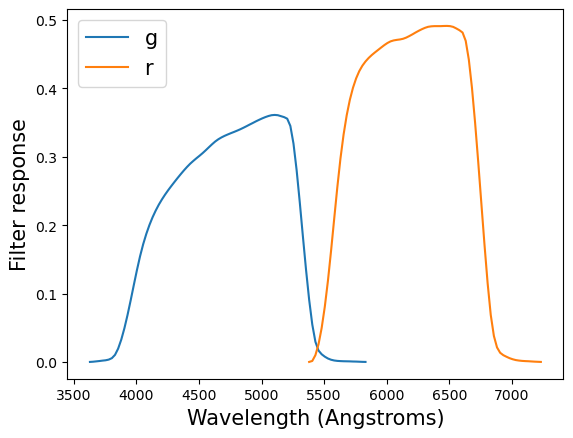

In [16]:
hdul = fits.open('filter_curves.fits')
labels = ['g', 'r']
band_response = dict()
band_lambda = dict()
for label in labels:
    data = hdul[label].data
    band_response[label] = data['respt']
    band_lambda[label] = data['wavelength']
    plt.plot(band_lambda[label], band_response[label], label=label)
hdul.close()
plt.xlabel ('Wavelength (Angstroms)',size=15)
plt.ylabel ('Filter response',size=15)
plt.legend (fontsize=15)
plt.show()

Then we read in and plot an example spectrum, shown below. It is a pretty typical red galaxy (i.e. elliptical) spectrum.

z: 0.15968972444534302
g magnitude: 19.606843963273363
r magnitude: 18.406296565148775


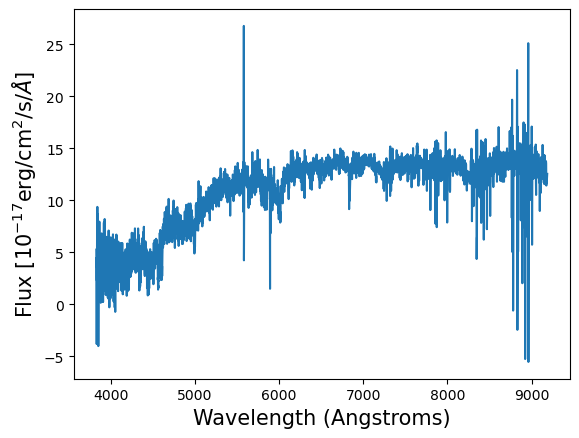

In [17]:
def read_spectra(filename):
    spec = fits.open(filename)
    z = spec[2].data['Z'][0]
    spectra = spec[1].data['flux']
    lam = 10.**spec[1].data['loglam']
    spec.close()
    return lam, spectra, z

def magnitude(lam, spectra):
    g_AB = 3631e-6 * c * 10**10 * lam**-2  # convert 3631 Jy to erg/cm^2/s/Ang
    a = simps(spectra * lam * np.interp(lam, band_lambda['g'], band_response['g']), lam)
    b = simps(g_AB * lam * np.interp(lam, band_lambda['g'], band_response['g']), lam)
    m_g = - 2.5 * np.log10(a / b)

    a = simps(spectra * lam * np.interp(lam, band_lambda['r'], band_response['r']), lam)
    b = simps(g_AB * lam * np.interp(lam, band_lambda['r'], band_response['r']), lam)
    m_r = - 2.5 * np.log10(a / b)
    
    return m_g, m_r

lam, spectra, redshift = read_spectra('spec-0274-51913-0320.fits')
m_g, m_r = magnitude(lam, spectra)
plt.plot(lam, spectra)
plt.xlabel('Wavelength (Angstroms)', size=15)
plt.ylabel(r'Flux [$10^{-17} \mathrm{erg} /\mathrm{cm}^2/\mathrm{s}/\AA$]', size=15)
print ('z: {}'.format(redshift))
print ('g magnitude: {}'.format(m_g))
print ('r magnitude: {}'.format(m_r))

Next, we calculate the K-corrections for the g and r bands associated with this spectrum. We do so using Equation (13) from Hogg et al. (2002). In our case, $Q=R=g$ or $Q=R=r$, so the terms associated with the standard source cancel. The equation becomes:

$$K(z) = -2.5\log_{10} \left[ \frac{1}{1+z} \frac{\int {\rm d}\lambda_o \lambda_o L_\lambda(\lambda_o/(1+z)) R(\lambda_o)} {\int {\rm d}\lambda_e \lambda_e L_\lambda(\lambda_e) R(\lambda_e)}\right]$$

In the calculation below, "spectra" is the equivalent of $L_\lambda$.

g-r color: 1.2005473981245878


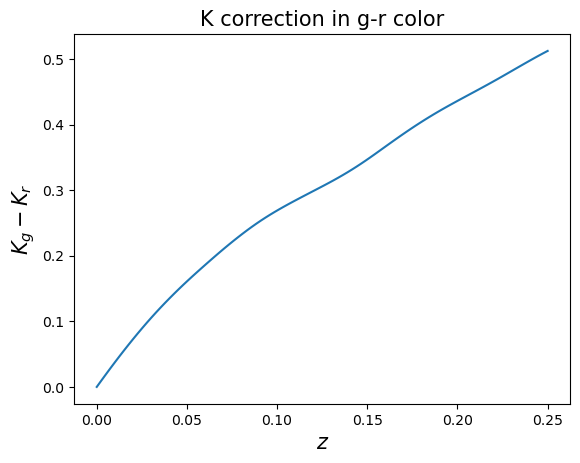

In [18]:
zs = np.linspace(0,0.25,100)

def Kgr_correction (lam, spectra, z, band_lambda, band_response):
    lam_e = lam / (1 + z)
    g_AB = 3631e-6 * c * 10**10 * lam**-2
    g_AB_e = 3631e-6 * c * 10**10 * lam_e**-2
    g_filter = np.interp(lam, band_lambda['g'], band_response['g'])
    r_filter = np.interp(lam, band_lambda['r'], band_response['r'])
    g_filter_e = np.interp(lam_e, lam, g_filter)
    r_filter_e = np.interp(lam_e, lam, r_filter)
    kg = - 2.5 * np.log10(1. / (1. + z) * simps(spectra * lam * g_filter, lam)
                          / simps(spectra * lam_e * g_filter_e, lam_e))
    kr = - 2.5 * np.log10(1. / (1. + z) * simps(spectra * lam * r_filter, lam)
                          / simps(spectra * lam_e * r_filter_e, lam_e))
    return (kg - kr)

kgr = np.zeros(len(zs))
for i, z in enumerate(zs):
    kgr[i] = Kgr_correction(lam, spectra, z, band_lambda, band_response)
    
plt.plot(zs, kgr)
plt.ylabel(r'$K_{g} - K_r$',size=15)
plt.xlabel(r'$z$',size=15)
plt.title ('K correction in g-r color',size=15)
print ('g-r color: {}'.format(m_g-m_r))

If this K-correction estimate is correct, and this galaxy is typical (and we can see above that it is a pretty typical elliptical galaxy spectrum) then the colors of galaxies in general should follow this K-correction. 

To do this, we take all the spectrum files we just downloaded and extract the photometric measurements (from the images) that are stored in those files. These measurements are of the centers of the galaxies. Note that it would be faster and easier to just download a sample of the photometry rather than full spectra. From these measurements, we plot $g-r$.

We then ask what the colors of our example galaxy would be. At the redshift of the galaxy, obviously the colors are just the observed colors. To infer what the colors would be at other redshifts, we need to use the K-correction:

$$(g-r)(z) = (g - r)_{\rm obs} - \left(K_g(z_{\rm obs}) - K_r(z_{\rm obs})\right) + \left(K_g(z) - K_r(z)\right)$$


In [19]:
allfiles = os.listdir()
specfiles = []
for allfile in allfiles:
    if(re.match('^spec-[0-9][0-9][0-9][0-9]-[0-9][0-9][0-9][0-9][0-9]-[0-9][0-9][0-9][0-9].fits$', allfile)):
        specfiles.append(allfile)

In [20]:
calibflux = np.zeros((len(specfiles), 5), dtype=np.float32)
zgal = np.zeros(len(specfiles), dtype=np.float32)
for i, specfile in enumerate(specfiles):
    f = fits.open(specfile)
    calibflux[i, :] = f[2].data['CALIBFLUX'].flatten()
    zgal[i] = f[2].data['Z']

In [21]:
kgr_observed = np.interp(redshift, zs, kgr)
gmr_predicted = m_g - m_r - kgr_observed + kgr

(-0.01, 0.26)

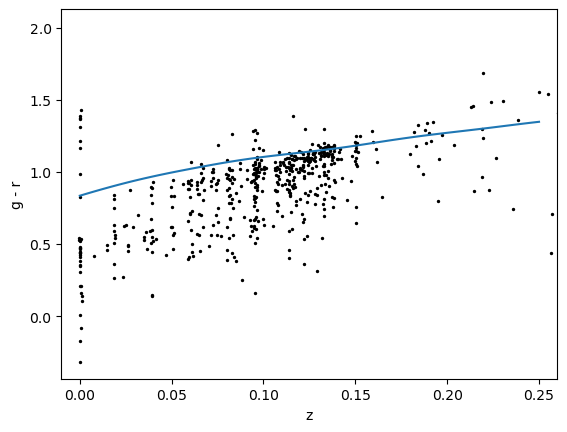

In [22]:
g = - 2.5 * np.log10(calibflux[:, 1])
r = - 2.5 * np.log10(calibflux[:, 2])
gmr = g - r
plt.plot(zs, gmr_predicted)
plt.scatter(zgal, gmr, s=2, color='black')
plt.xlabel('z')
plt.ylabel('g - r')
plt.xlim([-0.01, 0.26])

As noted above, the galaxy is intrinsically red like an elliptical galaxy. We see that the predicted colors get redder with redshift in a similar manner to the actual galaxies. The points at $z=0$ are stars. The dependence on redshift of the predictions is a little shallower than observed. This may be partly due to the properties of this particular galaxy, but it is also likely enhanced by the fact that the sample of galaxies is flux limited; the further galaxies are also more luminous, and therefore redder, which increases the dependence of color on redshift.

# 4. THINGS galaxies

*Author: Connor Hainje*

In [23]:
import requests

base_url = "https://www2.mpia-hd.mpg.de/THINGS/Data_files"

for moment in range(3):
    file_name = f"NGC_2403_NA_MOM{moment}_THINGS.FITS"
    url = f"{base_url}/{file_name}"

    if os.path.exists(file_name):
        print(f'{file_name} found')
        continue

    # https://stackoverflow.com/a/16696317
    with requests.get(url, stream=True) as req:
        req.raise_for_status()
        with open(file_name, "wb") as f:
            for chunk in req.iter_content(chunk_size=8192): 
                f.write(chunk)

    print(f"downloaded {file_name}")


NGC_2403_NA_MOM0_THINGS.FITS found
NGC_2403_NA_MOM1_THINGS.FITS found
NGC_2403_NA_MOM2_THINGS.FITS found


The code below is close enough if the image is North-up; if the image is not aligned with the RA/Dec coordinate system, there is a rotation that has to be dealt with. 

In [24]:
# I'm trying to figure out how to get the RA, DEC values for the pixels
head = fits.getheader('NGC_2403_NA_MOM1_THINGS.FITS')
ra_indices = np.arange(head['NAXIS1']) - head['CRPIX1']
#ra_vals = head['CRVAL1'] + 2 * head['CDELT1'] * ra_indices
#                          ^ don't know why I need to put 2 here, 
#                            but it makes it match the figure in the paper
ra_vals = (head['CRVAL1'] +
           head['CDELT1'] * ra_indices / np.cos(head['CRVAL2'] * np.pi / 180.))

dec_indices = np.arange(head['NAXIS2']) - head['CRPIX2']
dec_vals = head['CRVAL2'] + head['CDELT2'] * dec_indices

# stealing the ticks from the figure in the paper
ra_ticks = astropy.coordinates.Angle(['7h39m', '7h38m', '7h37m', '7h36m', '7h35m']).to(astropy.units.deg)
ra_ticklabels = [
    '$39^\mathrm{m}$',
    '$38^\mathrm{m}$',
    '$37^\mathrm{m}$',
    '$7^\mathrm{h} 36^\mathrm{m}$',
    '$35^\mathrm{m}$',
]

dec_ticks = astropy.coordinates.Angle(['65d28m', '65d36m', '65d44m']).to(astropy.units.deg)
dec_ticklabels = [
    r"$28'$",
    r"$65^\circ 36'$",
    r"$44'$"
]

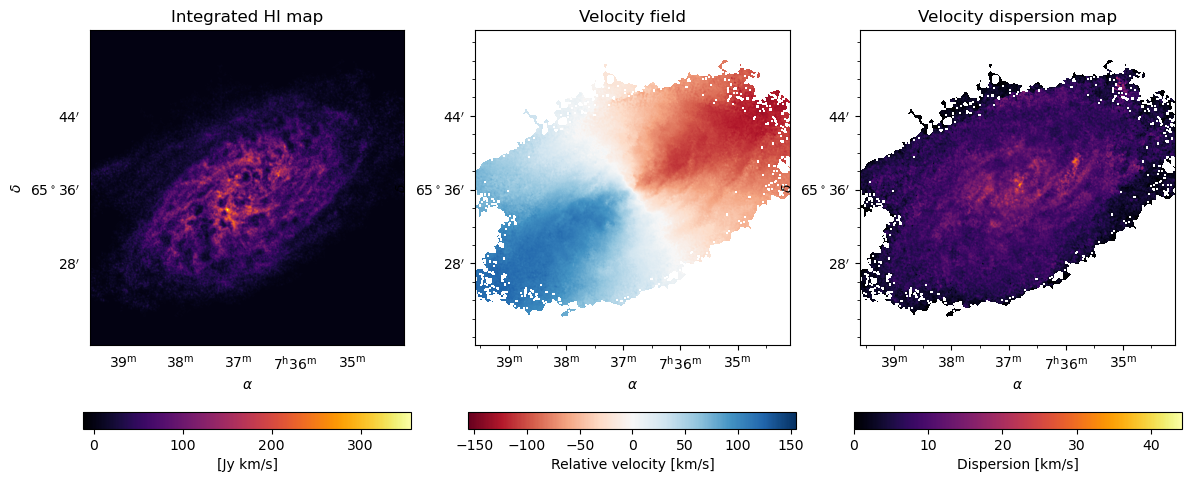

In [25]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

kw = dict(origin='lower',  # for naturalness
          extent=(ra_vals[0], ra_vals[-1], dec_vals[0], dec_vals[-1]),  # use the RA and Dec values for the axes that we calculated
          aspect=abs(ra_vals[-1] - ra_vals[0]) / abs(dec_vals[-1] - dec_vals[0]))  # make the plot square

titles = ['Integrated HI map', 'Velocity field', 'Velocity dispersion map']
cb_labels = ['[Jy km/s]', 'Relative velocity [km/s]', 'Dispersion [km/s]']


for i in range(3):
    ax = axs[i]

    x = fits.getdata(f'NGC_2403_NA_MOM{i}_THINGS.FITS')
    x = x.squeeze()

    if i == 1:
        x /= 1e3  # convert to km/s
        
        v_sys = 133.1  # from THINGS paper, table 1
        diff = x - v_sys
        vlim = np.nanmax(np.abs(diff))

        im = ax.imshow(diff, vmin=-vlim, vmax=+vlim, cmap='RdBu', **kw)

    else:
        if i == 2:
            x /= 1e3  # convert to km/s
        
        im = ax.imshow(x, cmap='inferno', **kw)

    ax.set_xlabel(r'$\alpha$')
    ax.set_ylabel(r'$\delta$')
    ax.set_title(titles[i])
    
    ax.set_xticks(ra_ticks.value)
    ax.set_xticklabels(ra_ticklabels)
    ax.set_yticks(dec_ticks.value)
    ax.set_yticklabels(dec_ticklabels)
    ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(abs(ra_ticks[1] - ra_ticks[0]).value / 2))
    ax.yaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(abs(dec_ticks[1] - dec_ticks[0]).value / 4))
    
    if i == 0:
        ax.tick_params(axis='both', which='both', color='white')

    fig.colorbar(im, label=cb_labels[i], ax=ax, location='bottom', shrink=0.5)

fig.tight_layout(w_pad=-20)
plt.show()


We have been asked to "eyeball" the rotation velocity. The radial velocity reported in the outermost parts of along the major axis is $\pm 150$ km s$^{-1}$. That is the component of the rotation velocity projected onto the line of sight.

However, this galaxy is not edge-on, so the full rotation velocity must be larger. If the galaxy is circular when viewed face-on, then its apparent axis ratio $b/a$ will tell us its inclination to the line of sight. The relationship should be:

$$\frac{b}{a} = \cos i$$

where $i$ is the inclination ($i=0$ at face-on). Then the line-of-sight component of the rotation velocity is:

$$v_{\rm los} = v_{\rm rot} \sin i  = \left(1 - \cos^2 i\right)^{1/2} v_{\rm rot} 
= \left[1 - \left(\frac{b}{a}\right)^2\right]^{1/2} v_{\rm rot} $$

or:

$$v_{\rm rot} = 
\left[1 - \left(\frac{b}{a}\right)^2\right]^{-1/2} v_{\rm los} $$

From the integrated HI map, I eyeball $b/a\sim 1/2$, which makes the factor about 1.15, so the true rotation velocity is about $175$ km s$^{-1}$.